# Model Example

In this initial experiment, we will attempt to predict the diagnosis of ASD from fMRI data using Graph Neural Networks. Each sample in the dataset corresponds to an fMRI exam, and from that exam, we construct a graph using a brain atlas reference, which will be the input for the GNN.

# Constructing the full set of graphs

An input graph to a GNN consists on a triple $G = (V, E, X)$, where $V$ is the set of notes, $E$ is the set of edges and $X$ is the feature matrix such that the $i$-th row of $X$ contains the feature vector of node $i$.

For the set $V$, the nodes of the graph will correspond to Regions Of Interest (ROI), where a region of interest is considered to have an important and specialized function in the brain connectivity. These regions can be categorized using a brain atlas, and here, we will use the AAL atlas, with 116 ROIs.

The set of edges $E$ is calculated using the functional connectivity of the brain. In an fMRI exam, each part of the brain has a BOLD signal, a time series that measures brain activity through the presence of blood. Edges in the graph are inserted for pairs of nodes that have high positive correlation in their correspondent BOLD signals.

Finally, inspired by the work of [Zhu et al.](https://link.springer.com/chapter/10.1007/978-3-030-93049-3_30), $X$ will be equal to the correlation matrix of the BOLD signals for all regions of interest. Therefore, the feature vector $i$ corresponds to it's partial correlations to every other region of interest in the brain.



## Import libraries

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import torch

In [2]:
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 27.5 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def torch_pearson_correlation_matrix(X):

  mean = torch.mean(X, dim=0)
  covariance = torch.matmul((X - mean).t(), (X - mean))
  variance = torch.diagonal(covariance)
  correlation = (variance**(-1/2)) * covariance * ((variance**(-1/2)).t())
  return correlation

def construct_graph(roi_time_series, threshold=0.7, return_functional_connectivity=True, adjacency_matrix_type='torch', adjacency_representation = 'edge_list'):

  roi_time_series = torch.from_numpy(roi_time_series).to(device)
  functional_connectivity = torch_pearson_correlation_matrix(roi_time_series)
  adjacency = (functional_connectivity > threshold).int().to(device) - torch.eye(len(functional_connectivity)).to(device)

  if adjacency_representation == 'edge_list':
    adjacency = (adjacency.nonzero()).t()

  if adjacency_matrix_type == 'numpy':
    adjacency = adjacency.cpu().numpy()

  if return_functional_connectivity==True:
    return adjacency, functional_connectivity
  else:
    return adjacency

Obtaining data from the ABIDE I [Preprocessed Connectomes Project](http://preprocessed-connectomes-project.org/abide/download.html), where all fMRI exams have been pre-processed with different brain atlases. As mentioned before, we will use the AAL atlas.

In [5]:
import os
import subprocess
from torch_geometric.data import Data
from tqdm import tqdm

def download_sample(sample_name):
  destination_folder = '/content/data/fmri'
  url = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_global/rois_aal/{}_rois_aal.1D'.format(sample_name)
  subprocess.run([
    "wget",
    "-P", destination_folder,
    "--continue",
    "--quiet",
    "--no-check-certificate",
    url
  ])

def get_dataset(threshold=0.7, data_source='download'):

  filepath_begin = ""
  if data_source == 'download':
    os.makedirs('/content/data/fmri', exist_ok=True)
    !wget -P /content/data https://raw.githubusercontent.com/preprocessed-connectomes-project/abide/master/Phenotypic_V1_0b_preprocessed1.csv
    phenotypic_data = pd.read_csv('/content/data/Phenotypic_V1_0b_preprocessed1.csv')
    print("Downloading fMRI scans...")
    phenotypic_data['FILE_ID'].apply(download_sample)
    filepath_begin = "/content/data/fmri/"

  elif data_source == 'drive':
    from google.colab import drive
    drive.mount('/content/drive')
    phenotypic_data = pd.read_csv('/content/drive/MyDrive/data/Phenotypic_V1_0b_preprocessed1.csv')
    filepath_begin = "/content/drive/MyDrive/data/fmri"

  data_list = []

  for index, row in tqdm(phenotypic_data.iterrows(), total=phenotypic_data.shape[0], desc='Constructing graphs:'):
    filepath = filepath_begin + row['FILE_ID'] + "_rois_aal.1D"
    if not os.path.exists(filepath): #Not every line of the phenotypic table is in the PCP dataset
      continue
    roi_time_series = np.loadtxt(filepath)
    edge_index, x = construct_graph(roi_time_series=roi_time_series, threshold=threshold)

    if torch.isnan(x).any():
      continue

    y = torch.tensor([row['DX_GROUP']-1]) #For the graph labels, 0 is for autistic patients and 1 is for typical control (adjusted to 0-1 interval to allow BCE Loss)
    data_list.append(Data(x=x, edge_index=edge_index, y=y))

  return data_list

In [6]:
dataset = get_dataset()

--2025-02-03 13:51:58--  https://raw.githubusercontent.com/preprocessed-connectomes-project/abide/master/Phenotypic_V1_0b_preprocessed1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 449443 (439K) [text/plain]
Saving to: ‘/content/data/Phenotypic_V1_0b_preprocessed1.csv’

Phenotypic_V1_0b_pr 100%[===================>] 438.91K  --.-KB/s    in 0.04s   

2025-02-03 13:51:58 (9.61 MB/s) - ‘/content/data/Phenotypic_V1_0b_preprocessed1.csv’ saved [449443/449443]



Constructing graphs:: 100%|██████████| 1112/1112 [00:05<00:00, 214.38it/s]


In [7]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

# Training the GNN

Here, we will use the Graph Attention Network architecture proposed by [Veličković et al.](https://arxiv.org/abs/1710.10903)

In [8]:
from torch.nn import ModuleList, Sigmoid
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import GATConv
from torch_geometric.nn.pool import global_mean_pool

class GAT(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim=8, n_heads=3, num_layers=3, dropout=0.5):

    super(GAT, self).__init__()
    self.dropout = dropout
    self.num_layers = num_layers

    self.convs = ModuleList()
    self.convs.append(GATConv(input_dim, hidden_dim, n_heads))
    for l in range(num_layers - 1):
      self.convs.append(GATConv(hidden_dim * n_heads, hidden_dim, n_heads))

    self.dropout = dropout
    self.post_message_passing = nn.Linear(hidden_dim * n_heads, 1)
    self.sigmoid = Sigmoid()

  def forward(self, data):

    x, edge_index, batch = data.x, data.edge_index, data.batch

    for i in range(self.num_layers):
      x = self.convs[i](x, edge_index)
      x = F.leaky_relu(x)
      x = F.dropout(x, p=self.dropout,training=self.training)

    x = global_mean_pool(x, batch)
    x = self.post_message_passing(x).squeeze(1)
    out = self.sigmoid(x)
    return out

In [9]:
from torch.nn.functional import binary_cross_entropy as BCELoss
from torch.optim import Adam

def train(train_loader, n_epochs=100, learning_rate = 0.01, return_losses = False):

  model = GAT(input_dim=116)
  model = model.to(device)
  optimizer = Adam(model.parameters(), lr=learning_rate)

  losses = []

  model.train()

  for epoch in tqdm(range(n_epochs), desc='Epochs: '):

    total_loss = 0
    for batch in train_loader:

      batch.x, batch.y = batch.x.float(), batch.y.float()
      optimizer.zero_grad()
      prediction = model(batch)
      true_label = (batch.y).to(device)
      loss = BCELoss(prediction, true_label)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * batch.num_graphs

    losses.append(total_loss)

  if return_losses:
    return model, losses
  return model

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def test(model, test_loader, losses):

  model.eval()

  test_prediction = []
  test_true_label = []

  for batch in test_loader:

    batch.x, batch.y = (batch.x.float()).to(device), (batch.y.float()).to(device)
    output = model(batch)
    y_batch_pred = torch.round(output)
    test_prediction.extend(y_batch_pred.cpu().detach().numpy())
    test_true_label.extend(batch.y.cpu().detach().numpy())

  print("Classification Report:")
  print(classification_report(test_true_label, test_prediction))

  plt.title("Decay of loss during training")
  plt.plot(losses)
  plt.show()

In [11]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
model, losses = train(train_loader, return_losses=True)

Epochs: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.51      0.52        87
         1.0       0.61      0.64      0.62       103

    accuracy                           0.58       190
   macro avg       0.57      0.57      0.57       190
weighted avg       0.58      0.58      0.58       190



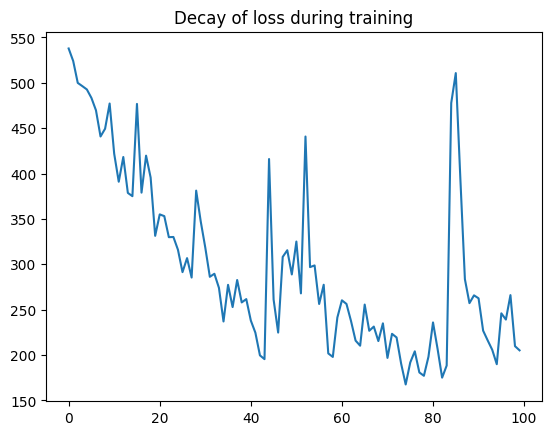

In [12]:
test(model, test_loader, losses)

# Model explanations